### Análise Exploratória de Dados para Textos

A Análise Exploratória de Dados (EDA) é uma etapa importante no fluxo de trabalho de qualquer projeto de ciência de dados. No entanto, ao trabalhar com dados de texto você precisará aplicar técnicas diferentes do trabalho com dados tabulares.

Veremos algumas técnicas para dados de texto:

1. Contagens: contagens de caracteres, contagens de palavras, contagens de frases e contagens de strings e também a média de comprimentos de palavras e frases.

2. Análise de frequência de termos: analisaremos as palavras e n-grams mais frequentes e discutiremos por que você não precisa de nuvens de palavras.

Para este artigo, foi usado o dataset de avaliações de roupas femininas da Kaggle 

[Women’s E-Commerce Clothing Reviews Dataset](https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews)

---

**Adaptado do post**: https://towardsdatascience.com/fundamental-eda-techniques-for-nlp-f81a93696a75

---

In [1]:
import pandas as pd

In [2]:
base = pd.read_csv("kaggle-clothing_reviews\\Womens Clothing E-Commerce Reviews.csv", index_col=0)

In [3]:
base.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


A base possui 23486 linhas e 10 colunas, vamos usar apenas duas "Review text", "Rating" e "Department Name".

In [4]:
import nltk
import numpy as np
from nltk.tokenize import sent_tokenize

In [5]:
df = base[['Review Text', 'Rating', 'Department Name']].dropna()

In [6]:
# Contagem de caracteres por avaliação
df["char_count"] = df["Review Text"].map(lambda x: len(x))

# Contagem de palavras por avaliação
df["word_count"] = df["Review Text"].map(lambda x: len(x.split()))

# Contagem de sentenças por avaliação
df["sent_count"] = df["Review Text"].map(lambda x: len(sent_tokenize(x)))

# Contagem de hashtags por avaliação
df["hashtag_count"] = df["Review Text"].map(lambda x: x.count("#"))

# Número médio de palavras por avaliação
df["avg_word_len"] = df["Review Text"].map(lambda x: np.mean([len(w) for w in str(x).split()]))

# Número médio de sentenças por avaliação
df["avg_sent_len"] = df["Review Text"].map(lambda x: np.mean([len(w.split()) for w in sent_tokenize(x)]))

Ok, agora temos uma visão quantitativa da nossa base:

In [7]:
df.head()

,Review Text,Rating,Department Name,char_count,word_count,sent_count,hashtag_count,avg_word_len,avg_sent_len
0,Absolutely wonderful - silky and sexy and comf...,4,Intimate,53,8,1,0,5.750000,8.000000
1,Love this dress! it's sooo pretty. i happene...,5,Dresses,303,62,6,0,3.822581,10.333333
2,I had such high hopes for this dress and reall...,3,Dresses,500,98,5,0,4.112245,19.600000
3,"I love, love, love this jumpsuit. it's fun, fl...",5,Bottoms,124,22,3,0,4.681818,7.333333
4,This shirt is very flattering to all due to th...,5,Tops,192,36,4,0,4.361111,9.250000


Vamos constuir algumas gráficos a partir dessas informações:

In [8]:
import seaborn as sns
from matplotlib import pyplot as plt

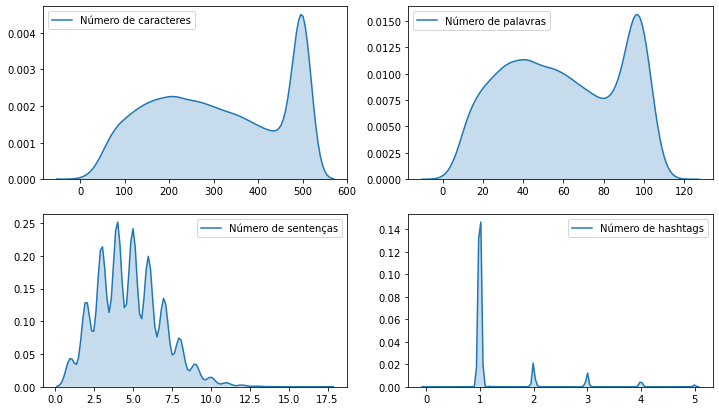

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(12,7))
sns.kdeplot(df['char_count'], shade=True, ax=ax[0,0], label='Número de caracteres')
sns.kdeplot(df['word_count'], shade=True, ax=ax[0,1], label='Número de palavras')
sns.kdeplot(df['sent_count'], shade=True, ax=ax[1,0], label='Número de sentenças')
sns.kdeplot(df['hashtag_count'], shade=True, ax=ax[1,1], label='Número de hashtags');

### Positivo versus Negativo

Vamos considerar as mensagens com "Rating = 1" como negativas e "Rating = 5" como positivas. Como será a distribuição das palavras em cada um dos casos? 

Para facilitar vou transformar o código anterior dos gráficos em uma função:

In [10]:
def plot_infos(df, color=None):
    fig, ax = plt.subplots(2, 2, figsize=(12,7))
    sns.kdeplot(df['char_count'], shade=True, ax=ax[0,0], label='Número de caracteres', color=color)
    sns.kdeplot(df['word_count'], shade=True, ax=ax[0,1], label='Número de palavras', color=color)
    sns.kdeplot(df['sent_count'], shade=True, ax=ax[1,0], label='Número de sentenças', color=color)
    sns.kdeplot(df['hashtag_count'], shade=True, ax=ax[1,1], label='Número de hashtags', color=color)

In [11]:
positivo = df[df.Rating == 5]
negativo = df[df.Rating == 1]

**Positivo**

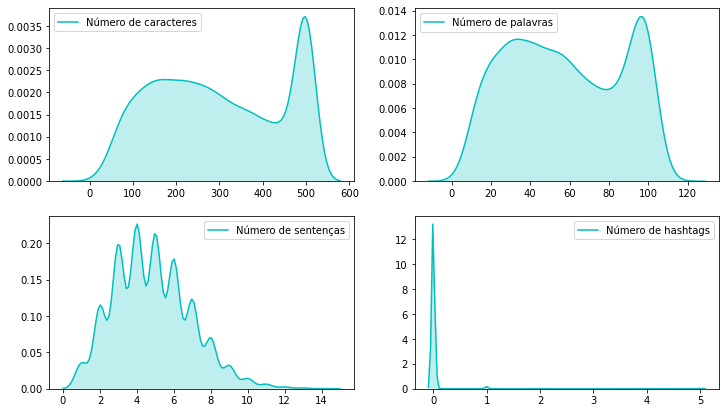

In [12]:
plot_infos(positivo, color='c')

**Negativo**

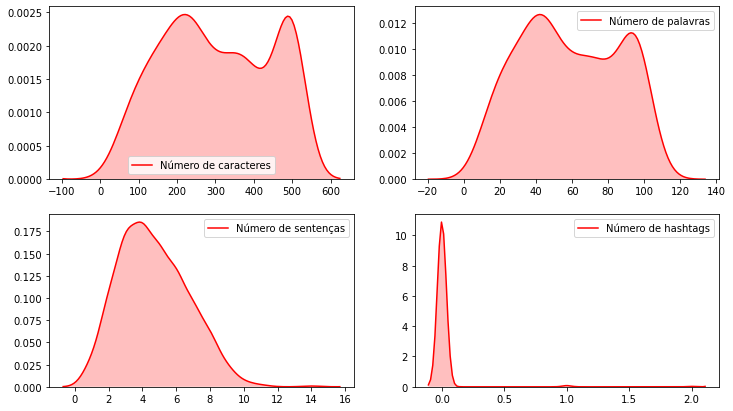

In [13]:
plot_infos(negativo, color='red')

### Análise de Frequência dos Termos

Nesta parte o mais comum é usar wordcloud para apresentar quais os termos mais frequentes, mas vamos optar por um gráfico de barras. Apesar de ter um impacto visual muito interessante a wordcloud pode confundir um pouco a análise. Embora os termos mais frequentes sejam exibidos em um tamanho de fonte maior do que os termos menos frequentes, é difícil entender a ordem entre as palavras igualmente frequentes.

Um gráfico de barras simples pode não ser tão chamativo quanto uma nuvem de palavras, mas faz um trabalho muito melhor na visualização da ordenação e frequência do termo.

Antes de começarmos, é necessário pré-processar o texto alterando tudo para minúsculas, removendo todas as pontuações e caracteres não romanos.

In [14]:
import re
import string

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def clean_text(text):
    
    # Texto para minúsculo
    text = text.lower()
    
    # Remove contrações (i'm, aren't, you're, can't..)
    text = decontracted(text)
    
    # Remoção de pontuações
    text = re.sub("[%s]" % re.escape(string.punctuation), "", text)
    
    # Remoção de caracteres não romanos
    text = re.sub("([^\x00-\x7F])+", " ", text)
    
    return text

df["text_clean"] = df["Review Text"].map(lambda x: clean_text(x))

Primeiro, vamos criar uma lista contendo as palavras mais relevantes do texto revisado. Por palavra “relevante”, quero dizer palavras que não são consideradas stopwords, isto é, palavras que ocorrem com muita frequência como artigos e preposições. Por exemplo, "é", "para", "um", "e", "de".

In [15]:
from collections import Counter
from nltk.corpus import stopwords

stop = set(stopwords.words("english"))

In [16]:
print(stop)

{'any', 'can', 'this', 'a', 'nor', 'o', 'them', 's', 'only', 'doing', 'her', 'didn', "wouldn't", "isn't", 'herself', 'yourselves', 'through', 'again', 'yours', 've', 'who', "don't", 'in', 'from', 'is', 'off', 'were', 'aren', 'with', 'against', 'being', 'to', 'will', 'each', 't', 'above', "mightn't", 'my', 'll', 'does', 'm', 'very', 'before', 'few', "didn't", 'our', 'until', 'y', 'having', 'most', 'at', 'those', 'out', 'what', 'of', "mustn't", 'down', 'no', 'where', 'the', 'because', "aren't", "haven't", 'was', 'do', 'd', 'had', 'but', 'am', 'then', 'haven', 'me', 'hasn', 'isn', "doesn't", 'you', 'did', 'mustn', 'been', 'he', "weren't", 'for', 'how', 'both', 'it', 'your', 'hers', 'such', "you're", 'while', 'below', 'when', 'now', 'than', 'other', 'she', "needn't", "wasn't", 'whom', 'are', 'further', 'myself', 'own', 'ours', "shan't", "won't", 'needn', 'that', "you'd", 'ma', "she's", 'wasn', "you've", 'all', 'up', 'during', 'its', 'mightn', 're', 'should', 'after', 'they', 'if', 'or', "i

In [17]:
corpus = [word for i in df["text_clean"].str.split().values.tolist() for word in i if (word not in stop)]

In [18]:
print(corpus[:50])

['absolutely', 'wonderful', 'silky', 'sexy', 'comfortable', 'love', 'dress', 'sooo', 'pretty', 'happened', 'find', 'store', 'glad', 'bc', 'never', 'would', 'ordered', 'online', 'bc', 'petite', 'bought', 'petite', '58', 'love', 'length', 'hits', 'little', 'knee', 'would', 'definitely', 'true', 'midi', 'someone', 'truly', 'petite', 'high', 'hopes', 'dress', 'really', 'wanted', 'work', 'initially', 'ordered', 'petite', 'small', 'usual', 'size', 'found', 'outrageously', 'small']


As 10 palavras mais frequentes da nossa base:

In [19]:
most_common = Counter(corpus).most_common(10)

In [20]:
print(most_common)

[('dress', 10466), ('love', 8910), ('size', 8685), ('top', 7327), ('fit', 7240), ('like', 6991), ('wear', 6409), ('would', 6088), ('great', 6073), ('fabric', 4759)]


Podemos criar um gráfico de barras horizontais:

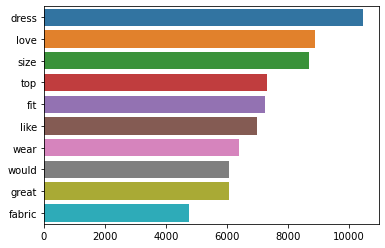

In [21]:
words, frequency = [], []
for word, count in most_common:
    words.append(word)
    frequency.append(count)
sns.barplot(x = frequency, y = words);

Quais as palavras positivas mais frequentes? e as negativas? Para facilitar vamos colocar os códigos anteriores em duas diferentes funções, uma para formação da lista de palavras e contagem e a segunda para plotar o gráfico de barra.

In [22]:
def get_most_common(df, k=10):
    corpus = [word for i in df["text_clean"].str.split().values.tolist() for word in i if (word not in stop)]
    return Counter(corpus).most_common(k)

def plot_freq_words(most_common, title = 'Freq Words', ax=None):
    words, frequency = [], []
    for word, count in most_common:
        words.append(word)
        frequency.append(count)
    sns.barplot(x = frequency, y = words, ax=ax).set_title(title)

In [23]:
positivo = df[df.Rating == 5]
negativo = df[df.Rating == 1]

In [24]:
neg_most_common = get_most_common(negativo, 10)
pos_most_common = get_most_common(positivo, 10)

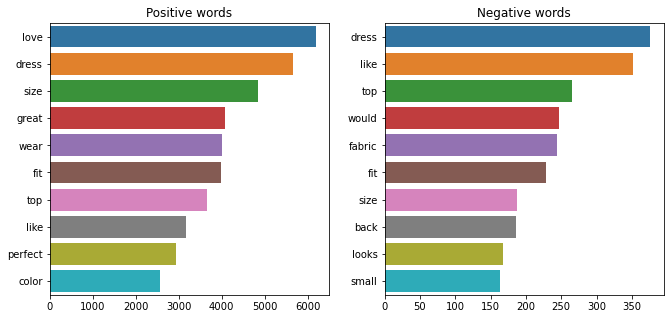

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(11,5))
plot_freq_words(pos_most_common, 'Positive words', ax=ax[0])
plot_freq_words(neg_most_common, 'Negative words', ax=ax[1])

### N-gramas mais frequentes

Vamos fazer o mesmo para n-grams. O que é um n-gram? É uma sequência de n palavras em um texto.

Para separar os textos em n-grams, você pode usar a classe CountVectorizer conforme mostrado abaixo.

No ngram_range você define os n-grams a serem considerados. Por exemplo. ngram_range = (2, 2) considera apenas bigramas, ngram_range = (3, 3) considera apenas trigramas e ngram_range = (2, 3) considera bigramas e trigramas.

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

# Considera apenas as palavras que aparecem pelo menos 100 vezes na base
vec = CountVectorizer(stop_words = stop, ngram_range = (2, 2), min_df=100)

# Matriz de ngrams
bow = vec.fit_transform(df["text_clean"])

# Contagem dos ngrams
count_values = bow.toarray().sum(axis=0)

# DataFrame a partir da contagem de ngrams
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in vec.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

In [27]:
ngram_freq.head(5)

,frequency,ngram
0,1297,true size
1,722,love dress
2,690,usually wear
3,618,looks great
4,598,fit perfectly


In [28]:
ngram_most_common = ngram_freq.head(10)

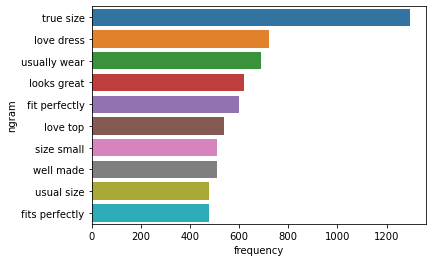

In [29]:
sns.barplot(x = ngram_most_common['frequency'], y = ngram_most_common['ngram']);

Abaixo você pode ver os bi e trigramas separados por avaliações positivas e negativas:

In [30]:
def get_ngram_freqs(df, n_min = 2, n_max=2, min_df=10):
    vec = CountVectorizer(stop_words = stop, ngram_range = (n_min, n_max), min_df=min_df) # aparececa pelo menos 100
    bow = vec.fit_transform(df["text_clean"])
    count_values = bow.toarray().sum(axis=0)
    ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in vec.vocabulary_.items()], reverse = True))
    ngram_freq.columns = ["frequency", "ngram"]
    return ngram_freq

In [31]:
neg_ngram = get_ngram_freqs(negativo).head(10)
pos_ngram = get_ngram_freqs(positivo).head(10)

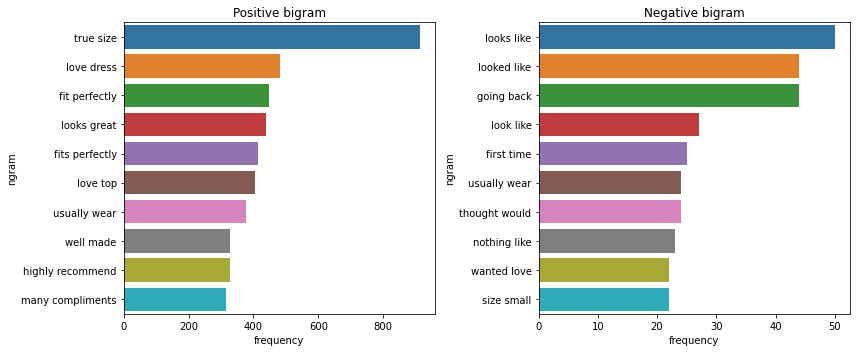

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
sns.barplot(x = pos_ngram['frequency'], y = pos_ngram['ngram'], ax=ax1).set_title("Positive bigram")
sns.barplot(x = neg_ngram['frequency'], y = neg_ngram['ngram'], ax=ax2).set_title("Negative bigram")
fig.tight_layout()

In [33]:
neg_ngram = get_ngram_freqs(negativo, n_min=3, n_max=3, min_df=2).head(10)
pos_ngram = get_ngram_freqs(positivo, n_min=3, n_max=3, min_df=2).head(10)

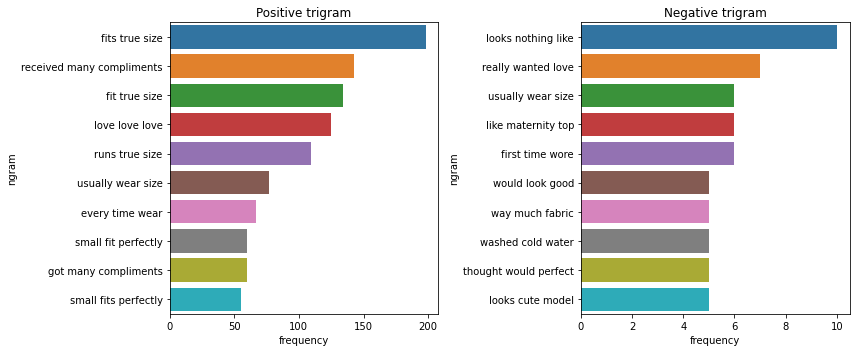

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
sns.barplot(x = pos_ngram['frequency'], y = pos_ngram['ngram'], ax=ax1).set_title("Positive trigram")
sns.barplot(x = neg_ngram['frequency'], y = neg_ngram['ngram'], ax=ax2).set_title("Negative trigram")
fig.tight_layout()

### Outras análises

In [35]:
from itertools import chain
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer

In [36]:
lemmatizer = WordNetLemmatizer()

In [37]:
corpus = [word for i in df["text_clean"].str.split().values.tolist() for word in i if (word not in stop)]
corpus_lemma = [lemmatizer.lemmatize(word) for word in corpus]

In [38]:
freq = pd.DataFrame.from_dict(Counter(corpus_lemma), orient='index').reset_index()
freq.rename(columns={'index':'word', 0:'count'}, inplace=True)

In [39]:
freq['tag'] = [v for k, v in pos_tag(list(freq.word))]

In [40]:
adjs = freq[freq.tag.isin(['JJ','JJR','JJS'])].sort_values('count', ascending=False).head(10)
nns = freq[freq.tag.isin(['NN'])].sort_values('count', ascending=False).head(10)

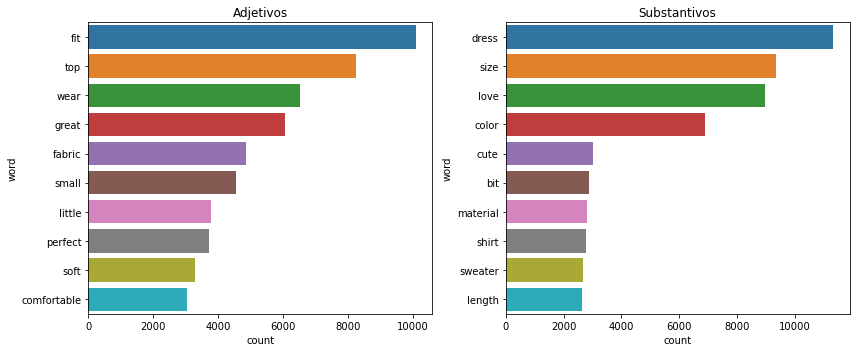

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
sns.barplot(x = adjs['count'], y = adjs['word'], ax=ax1).set_title("Adjetivos")
sns.barplot(x = nns['count'], y = nns['word'], ax=ax2).set_title("Substantivos")
fig.tight_layout()

In [42]:
def get_tags_words(df):
    corpus = [word for i in df["text_clean"].str.split().values.tolist() for word in i if (word not in stop)]
    corpus_lemma = [lemmatizer.lemmatize(word) for word in corpus]
    freq = pd.DataFrame.from_dict(Counter(corpus_lemma), orient='index').reset_index()
    freq.rename(columns={'index':'word', 0:'count'}, inplace=True)
    freq['tag'] = [v for k, v in pos_tag(list(freq.word))]
    return freq.sort_values('count', ascending=False)

def get_tags(df, tags, k=10):
    return df[df.tag.isin(tags)].head(k)

In [43]:
pos_tags = get_tags_words(positivo)
neg_tags = get_tags_words(negativo)

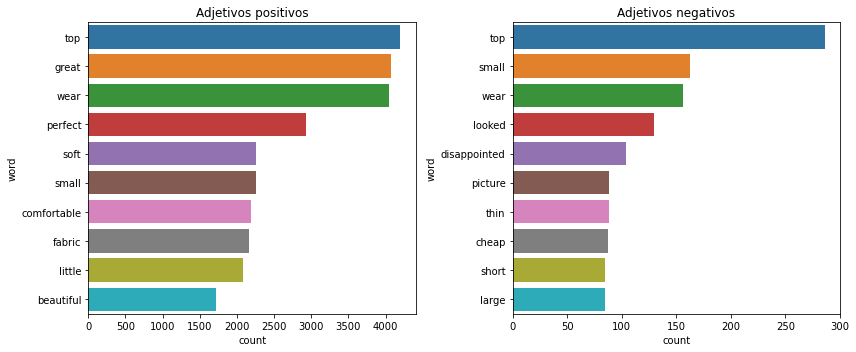

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
sns.barplot(x = get_tags(pos_tags, ['JJ','JJR','JJS'])['count'], y = get_tags(pos_tags, ['JJ','JJR','JJS'])['word'], ax=ax[0]).set_title("Adjetivos positivos")
sns.barplot(x = get_tags(neg_tags, ['JJ','JJR','JJS'])['count'], y = get_tags(neg_tags, ['JJ','JJR','JJS'])['word'], ax=ax[1]).set_title("Adjetivos negativos")
fig.tight_layout()

## Análise por departamento

In [45]:
adj = ['JJ','JJR','JJS']

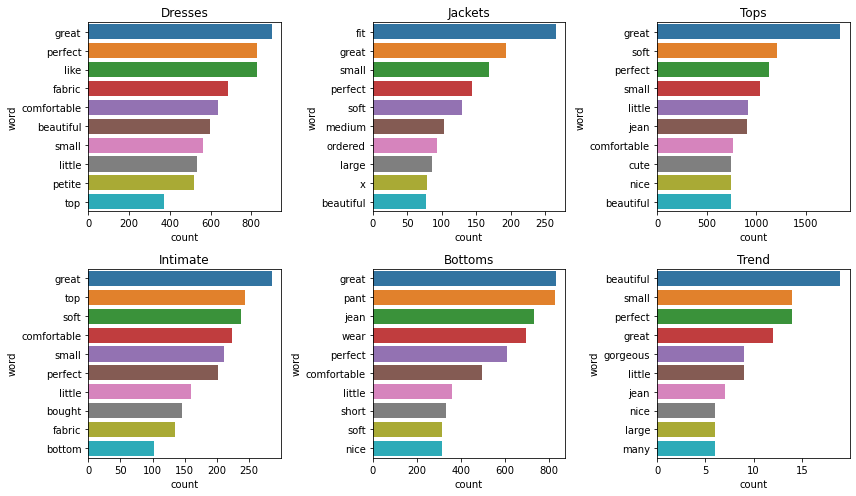

In [46]:
fig, ax = plt.subplots(2, 3, figsize=(12,7))
for i, department in enumerate(positivo['Department Name'].unique()):  
    tags_dept = get_tags_words(positivo[positivo['Department Name'] == department])
    sns.barplot(x = get_tags(tags_dept, adj)['count'], y = get_tags(tags_dept, adj)['word'], ax=ax[i%2,  i%3]).set_title(department)
fig.tight_layout()

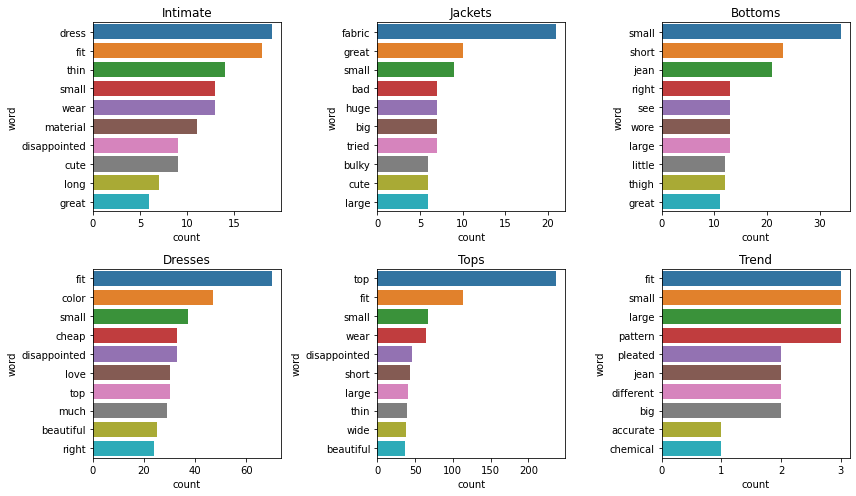

In [47]:
fig, ax = plt.subplots(2, 3, figsize=(12,7))
for i, department in enumerate(negativo['Department Name'].unique()):  
    tags_dept = get_tags_words(negativo[negativo['Department Name'] == department])
    sns.barplot(x = get_tags(tags_dept, adj)['count'], y = get_tags(tags_dept, adj)['word'], ax=ax[i%2,  i%3]).set_title(department)
fig.tight_layout()